In [7]:
import numpy as np
from lattice_class import *
from hamiltonian_constructor_class import *
import scipy.linalg
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150

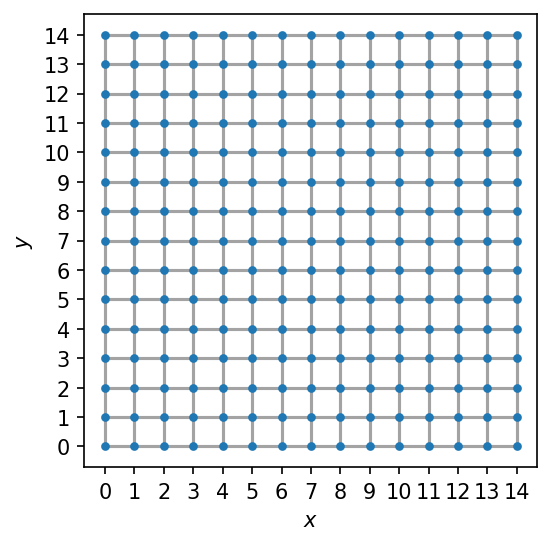

In [8]:
N = 15
lattice = SquareLattice(N, "open")

lattice.plot()
num_sites = lattice.get_num_sites()

lattice_sites = lattice.get_sites()
lattice_bonds = lattice.get_bonds()

True
Lowest found energy:  0.04609703581866668
Index of lowest absolute energy:  449
[-0.49346921 -0.40762088 -0.40762088 -0.31937208 -0.31937208 -0.22932274
 -0.22932274 -0.13808106 -0.13808106 -0.04609704 -0.04609704  0.04609704
  0.04609704  0.13808106  0.13808106  0.22932274  0.22932274  0.31937208
  0.31937208  0.40762088]


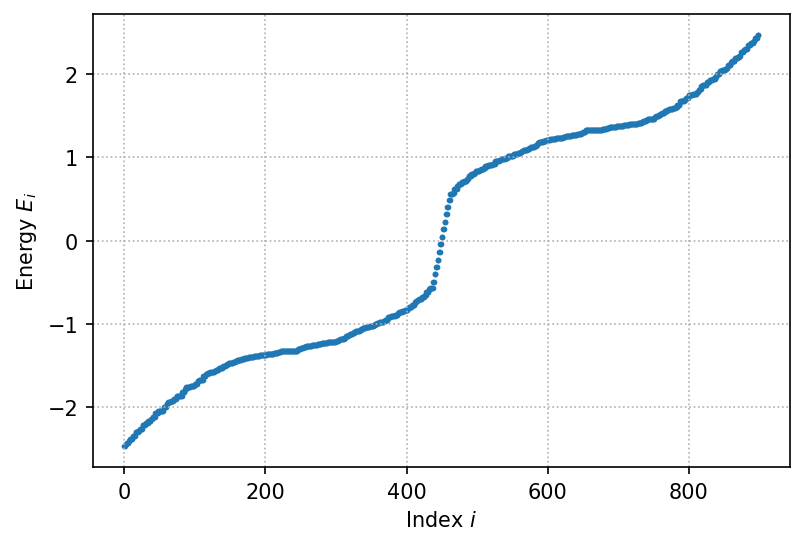

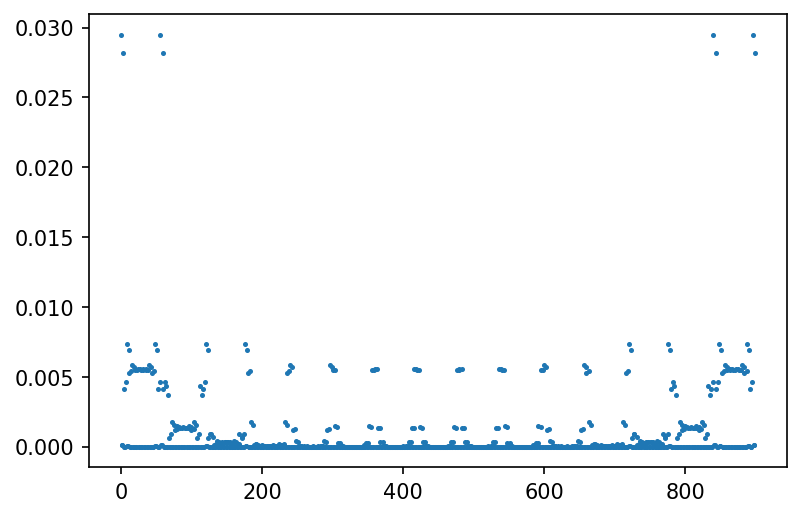

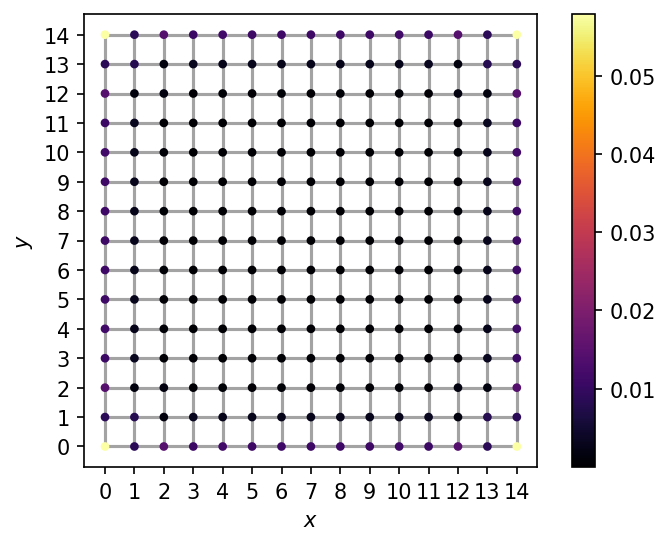

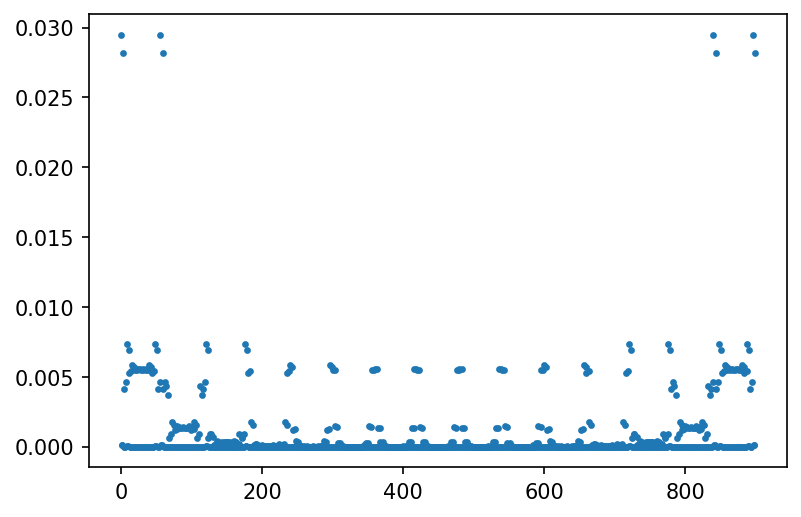

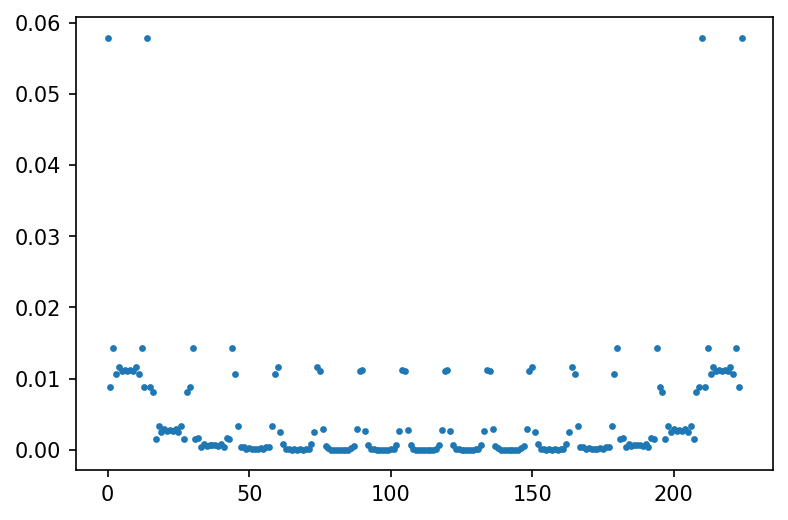

In [9]:

t = 1.0
mu = 1.0*t
delta = complex(t, 0.0)

dim_H_BdG = 4

Ham_constructor = HamiltonianConstructor(mu, t, t, delta)

H_direct_lattice = Ham_constructor.construct_direct_lattice_hamiltonian(lattice)
print(Ham_constructor._particle_hole_sym_check(H_direct_lattice, num_sites))
energies, states = scipy.linalg.eigh(H_direct_lattice)

print("Lowest found energy: ", np.min(np.abs(energies)))
gs_idx = np.argmin(np.abs(energies))
print("Index of lowest absolute energy: ", gs_idx)
print(energies[gs_idx-10:gs_idx+10])

plt.xlabel(r"Index $i$")
plt.ylabel(r"Energy $E_{i}$")
plt.grid(linestyle=":")
# plt.title("Energy Eigenvalues of Chiral p-wave SC")
plt.scatter(range(len(energies)), energies, s=3)
plt.savefig("./plots/square_lattice_spectrum_majorana_state.svg")
plt.show()

gs_wave_function = states[:, gs_idx]
gs_probabilities_nambu = np.square(np.abs(gs_wave_function))

plt.scatter(range(len(gs_probabilities_nambu)), gs_probabilities_nambu, s=2)
plt.show()

gs_probabilities = np.zeros(shape=(num_sites, 1))
block_indices = [
    slice(block_idx * dim_H_BdG, (block_idx + 1) * dim_H_BdG)
    for block_idx in range(lattice.get_num_sites())
]

for site_idx in range(num_sites):
    gs_probabilities[site_idx] = np.sum(gs_probabilities_nambu[block_indices[site_idx]])

x_values = [k[0] for k in lattice_sites]
y_values = [k[1] for k in lattice_sites]

color_map = plt.get_cmap("inferno")
sc = lattice.plot(False, c=(gs_probabilities), cmap=color_map)
plt.colorbar(sc)
plt.savefig("./plots/square_lattice_prob_distr_majorana_state.svg")
plt.show()

plt.scatter(range(len(gs_probabilities_nambu)), gs_probabilities_nambu, s=5)
plt.show()

plt.scatter(range(len(gs_probabilities)), gs_probabilities, s=5)
plt.show()